In [101]:
import torch
from dataloaders.beat import CustomDataset
from dataloaders.build_vocab import Vocab
import pickle
import numpy as np

config_file = open("camn_config.obj", 'rb') 
args = pickle.load(config_file)
args.batch_size = 8

In [102]:
train_data = CustomDataset(args, "train")
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=args.batch_size,  
    shuffle=True,  
    drop_last=True,
)

In [103]:
len(train_loader)

29714

In [31]:
val_data = CustomDataset(args, "val")
val_loader = torch.utils.data.DataLoader(
    val_data, 
    batch_size=args.batch_size,  
    shuffle=True,  
    drop_last=True,
)

In [17]:
len(val_loader)

5944

### Test A2BS SimpleNet

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scripts.Dataset import a2bsDataset
from scripts.SimpleNet import FaceGenerator, RMSLELoss

In [23]:
net = FaceGenerator().cuda()
optimizer = torch.optim.Adam( net.parameters(), lr=1e-3, weight_decay=1e-5)
loss_function = torch.nn.MSELoss()
train_loss = []
val_loss = []

In [9]:
print(len(train_data))
data = next(iter(train_loader))
in_audio = data['audio']
facial = data['facial']

237714


In [32]:
from tqdm import tqdm
num_epochs = 2
log_period = 500
val_period = 800
val_size = 200

for epoch in range(num_epochs):
    for it, data in enumerate(tqdm(train_loader)):
        net.train()
        in_audio = data['audio']
        facial = data['facial']

        in_audio = in_audio.cuda()
        facial = facial.cuda()
        pre_frames = 4
        in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1)).cuda()
        in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
        in_pre_face[:, 0:pre_frames, -1] = 1 
        
        optimizer.zero_grad()
        out_face = net(in_pre_face,in_audio)
        loss = loss_function(facial, out_face)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()
        
        #logging
        if it % log_period == 0:
            print(f'[{epoch}][{it}/{len(train_loader)}] loss: {loss.item()}')
        
        if it % val_period == 0:
            net.eval()
            val_loss_st = []
            val_cnt = 0
            
            for _, data in enumerate(val_loader):
                in_audio = data['audio']
                facial = data['facial']
                in_audio = in_audio.cuda()
                facial = facial.cuda()
                pre_frames = 4
                in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1)).cuda()
                in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
                in_pre_face[:, 0:pre_frames, -1] = 1 

                out_face = net(in_pre_face,in_audio)
                loss = loss_function(facial, out_face)
                val_loss_st.append(loss.item())
                
                val_cnt += 1
                if val_cnt >= val_size:
                    break
            
            val_loss.append(np.average(val_loss_st))
            print(f'[{epoch}][{it}/{len(train_loader)}] eval loss: {np.average(val_loss_st)}')

  0%|          | 0/29714 [00:00<?, ?it/s]

[0][0/29714] loss: 0.3414633870124817


  0%|          | 3/29714 [00:07<17:11:53,  2.08s/it]

[0][0/29714] eval loss: 0.4298314341902733


  2%|▏         | 504/29714 [00:34<26:26, 18.41it/s] 

[0][500/29714] loss: 0.40286949276924133


  3%|▎         | 804/29714 [00:56<5:36:04,  1.43it/s]

[0][800/29714] eval loss: 0.3982644357532263


  3%|▎         | 1003/29714 [01:06<21:02, 22.75it/s] 

[0][1000/29714] loss: 0.6909908056259155


  5%|▌         | 1504/29714 [01:28<21:01, 22.36it/s]

[0][1500/29714] loss: 0.36457177996635437


  5%|▌         | 1603/29714 [01:37<4:12:48,  1.85it/s]

[0][1600/29714] eval loss: 0.4115496639162302


  7%|▋         | 2002/29714 [01:57<21:16, 21.70it/s]  

[0][2000/29714] loss: 0.5528446435928345


  8%|▊         | 2404/29714 [02:20<2:51:46,  2.65it/s]

[0][2400/29714] eval loss: 0.4098760874569416


  8%|▊         | 2502/29714 [02:24<21:19, 21.27it/s]  

[0][2500/29714] loss: 0.2922022342681885


 10%|█         | 3003/29714 [02:50<22:21, 19.91it/s]

[0][3000/29714] loss: 0.3185561001300812


 11%|█         | 3204/29714 [03:05<3:11:18,  2.31it/s]

[0][3200/29714] eval loss: 0.407112832441926


 12%|█▏        | 3503/29714 [03:19<20:42, 21.09it/s]  

[0][3500/29714] loss: 0.40660321712493896


 13%|█▎        | 4000/29714 [03:44<28:23, 15.09it/s]

[0][4000/29714] loss: 0.6125776767730713


 13%|█▎        | 4004/29714 [03:50<4:50:08,  1.48it/s]

[0][4000/29714] eval loss: 0.40033208310604096


 15%|█▌        | 4504/29714 [04:15<20:51, 20.15it/s]  

[0][4500/29714] loss: 0.3301752507686615


 16%|█▌        | 4803/29714 [04:35<3:37:09,  1.91it/s]

[0][4800/29714] eval loss: 0.4095934668928385


 17%|█▋        | 5002/29714 [04:44<19:42, 20.90it/s]  

[0][5000/29714] loss: 0.4028263986110687


 19%|█▊        | 5503/29714 [05:08<18:54, 21.34it/s]

[0][5500/29714] loss: 0.3849290609359741


 19%|█▉        | 5605/29714 [05:17<2:23:53,  2.79it/s]

[0][5600/29714] eval loss: 0.3890261469036341


 20%|██        | 6003/29714 [05:36<19:09, 20.63it/s]  

[0][6000/29714] loss: 0.6710983514785767


 22%|██▏       | 6405/29714 [05:59<2:25:35,  2.67it/s]

[0][6400/29714] eval loss: 0.39852427497506143


 22%|██▏       | 6503/29714 [06:04<18:21, 21.07it/s]  

[0][6500/29714] loss: 0.4328107535839081


 24%|██▎       | 7002/29714 [06:28<17:23, 21.77it/s]

[0][7000/29714] loss: 0.24748529493808746


 24%|██▍       | 7204/29714 [06:42<2:26:51,  2.55it/s]

[0][7200/29714] eval loss: 0.3976067690551281


 25%|██▌       | 7504/29714 [06:57<17:56, 20.64it/s]  

[0][7500/29714] loss: 0.49285244941711426


 27%|██▋       | 8000/29714 [07:21<16:52, 21.45it/s]

[0][8000/29714] loss: 0.3939881920814514


 27%|██▋       | 8003/29714 [07:26<3:05:02,  1.96it/s]

[0][8000/29714] eval loss: 0.39791336834430696


 29%|██▊       | 8504/29714 [07:50<18:14, 19.38it/s]  

[0][8500/29714] loss: 0.6479748487472534


 30%|██▉       | 8804/29714 [08:10<2:19:34,  2.50it/s]

[0][8800/29714] eval loss: 0.39760150492191315


 30%|███       | 9002/29714 [08:20<16:58, 20.33it/s]  

[0][9000/29714] loss: 0.48302340507507324


 32%|███▏      | 9503/29714 [08:44<16:22, 20.57it/s]

[0][9500/29714] loss: 0.4012114405632019


 32%|███▏      | 9602/29714 [08:54<3:01:48,  1.84it/s]

[0][9600/29714] eval loss: 0.39590212851762774


 34%|███▎      | 10004/29714 [09:12<15:15, 21.53it/s] 

[0][10000/29714] loss: 1.239579677581787


 35%|███▌      | 10403/29714 [09:36<2:46:53,  1.93it/s]

[0][10400/29714] eval loss: 0.4065346294641495


 35%|███▌      | 10504/29714 [09:41<15:02, 21.28it/s]  

[0][10500/29714] loss: 0.43367651104927063


 37%|███▋      | 11002/29714 [10:04<14:48, 21.06it/s]

[0][11000/29714] loss: 0.4378832280635834


 38%|███▊      | 11203/29714 [10:19<2:44:44,  1.87it/s]

[0][11200/29714] eval loss: 0.4499639955163002


 39%|███▊      | 11504/29714 [10:34<15:13, 19.94it/s]  

[0][11500/29714] loss: 0.56376713514328


 40%|████      | 11999/29714 [10:58<15:01, 19.66it/s]

[0][12000/29714] loss: 0.2920514643192291


 40%|████      | 12003/29714 [11:04<2:59:39,  1.64it/s]

[0][12000/29714] eval loss: 0.42703104875981807


 42%|████▏     | 12505/29714 [11:28<13:50, 20.73it/s]  

[0][12500/29714] loss: 0.550106942653656


 43%|████▎     | 12803/29714 [11:48<2:08:35,  2.19it/s]

[0][12800/29714] eval loss: 0.39791773214936255


 44%|████▍     | 13002/29714 [11:57<13:32, 20.58it/s]  

[0][13000/29714] loss: 0.2741999328136444


 45%|████▌     | 13503/29714 [12:22<13:10, 20.51it/s]

[0][13500/29714] loss: 0.5303595662117004


 46%|████▌     | 13603/29714 [13:06<1:50:35,  2.43it/s] 

[0][13600/29714] eval loss: 0.41197584427893164


 47%|████▋     | 14004/29714 [13:25<12:16, 21.34it/s]  

[0][14000/29714] loss: 0.4506731629371643


 48%|████▊     | 14403/29714 [13:49<2:16:11,  1.87it/s]

[0][14400/29714] eval loss: 0.38805711522698405


 49%|████▉     | 14502/29714 [13:54<12:16, 20.65it/s]  

[0][14500/29714] loss: 0.27151408791542053


 50%|█████     | 15003/29714 [14:18<11:41, 20.97it/s]

[0][15000/29714] loss: 0.29245561361312866


 51%|█████     | 15203/29714 [14:33<1:50:54,  2.18it/s]

[0][15200/29714] eval loss: 0.38880218110978604


 52%|█████▏    | 15504/29714 [14:48<11:44, 20.17it/s]  

[0][15500/29714] loss: 0.4239416718482971


 54%|█████▍    | 16000/29714 [15:12<11:04, 20.64it/s]

[0][16000/29714] loss: 0.448436975479126


 54%|█████▍    | 16003/29714 [15:18<2:10:49,  1.75it/s]

[0][16000/29714] eval loss: 0.39888866201043127


 56%|█████▌    | 16503/29714 [15:42<10:49, 20.33it/s]  

[0][16500/29714] loss: 0.33092737197875977


 57%|█████▋    | 16803/29714 [16:02<1:40:20,  2.14it/s]

[0][16800/29714] eval loss: 0.40044090248644354


 57%|█████▋    | 17004/29714 [16:12<10:28, 20.23it/s]  

[0][17000/29714] loss: 0.5723590850830078


 59%|█████▉    | 17505/29714 [16:36<09:13, 22.04it/s]

[0][17500/29714] loss: 0.3977382183074951


 59%|█████▉    | 17603/29714 [16:46<1:32:41,  2.18it/s]

[0][17600/29714] eval loss: 0.38899423107504844


 61%|██████    | 18003/29714 [17:05<08:52, 21.98it/s]  

[0][18000/29714] loss: 0.382657527923584


 62%|██████▏   | 18404/29714 [17:29<1:19:13,  2.38it/s]

[0][18400/29714] eval loss: 0.3893146889656782


 62%|██████▏   | 18502/29714 [17:34<08:44, 21.39it/s]  

[0][18500/29714] loss: 0.4028503894805908


 64%|██████▍   | 19003/29714 [17:58<08:22, 21.31it/s]

[0][19000/29714] loss: 0.34451761841773987


 65%|██████▍   | 19203/29714 [18:13<1:22:21,  2.13it/s]

[0][19200/29714] eval loss: 0.3692601364850998


 66%|██████▌   | 19503/29714 [21:57<11:41, 14.55it/s]   

[0][19500/29714] loss: 0.5396168231964111


 67%|██████▋   | 20000/29714 [22:22<08:44, 18.53it/s]

[0][20000/29714] loss: 0.3976631760597229


 67%|██████▋   | 20004/29714 [22:28<1:58:45,  1.36it/s]

[0][20000/29714] eval loss: 0.38882072784006594


 69%|██████▉   | 20503/29714 [22:54<07:54, 19.39it/s]  

[0][20500/29714] loss: 0.3345929980278015


 70%|███████   | 20802/29714 [23:16<2:12:01,  1.13it/s]

[0][20800/29714] eval loss: 0.43334228701889516


 71%|███████   | 21004/29714 [23:28<08:54, 16.30it/s]  

[0][21000/29714] loss: 2.7649710178375244


 72%|███████▏  | 21504/29714 [23:53<07:05, 19.31it/s]

[0][21500/29714] loss: 0.4174145758152008


 73%|███████▎  | 21603/29714 [24:04<1:23:12,  1.62it/s]

[0][21600/29714] eval loss: 0.3868215012550354


 74%|███████▍  | 22003/29714 [24:25<07:05, 18.13it/s]  

[0][22000/29714] loss: 0.3814326822757721


 75%|███████▌  | 22403/29714 [24:50<1:00:42,  2.01it/s]

[0][22400/29714] eval loss: 0.3892231636494398


 76%|███████▌  | 22505/29714 [24:55<05:54, 20.33it/s]  

[0][22500/29714] loss: 0.8755354285240173


 77%|███████▋  | 23005/29714 [25:19<05:08, 21.76it/s]

[0][23000/29714] loss: 0.4707965850830078


 78%|███████▊  | 23203/29714 [25:33<1:02:20,  1.74it/s]

[0][23200/29714] eval loss: 0.3941230496019125


 79%|███████▉  | 23503/29714 [25:48<05:11, 19.93it/s]  

[0][23500/29714] loss: 0.27186164259910583


 81%|████████  | 23999/29714 [26:13<04:23, 21.70it/s]

[0][24000/29714] loss: 0.3347961902618408


 81%|████████  | 24002/29714 [26:19<59:11,  1.61it/s]

[0][24000/29714] eval loss: 0.38984091140329835


 82%|████████▏ | 24502/29714 [26:59<07:59, 10.87it/s]

[0][24500/29714] loss: 0.3453444242477417


 83%|████████▎ | 24803/29714 [27:22<39:30,  2.07it/s]

[0][24800/29714] eval loss: 0.37736077278852465


 84%|████████▍ | 25003/29714 [27:32<03:44, 20.96it/s]

[0][25000/29714] loss: 0.5668075680732727


 86%|████████▌ | 25503/29714 [28:05<04:13, 16.61it/s]

[0][25500/29714] loss: 0.3573441505432129


 86%|████████▌ | 25602/29714 [28:20<1:23:14,  1.21s/it]

[0][25600/29714] eval loss: 0.39079216949641704


 88%|████████▊ | 26002/29714 [28:59<05:33, 11.14it/s]  

[0][26000/29714] loss: 0.3553510904312134


 89%|████████▉ | 26403/29714 [29:30<31:37,  1.74it/s]

[0][26400/29714] eval loss: 0.39493490040302276


 89%|████████▉ | 26504/29714 [29:35<02:28, 21.66it/s]

[0][26500/29714] loss: 0.2682868242263794


 91%|█████████ | 27003/29714 [30:00<02:07, 21.31it/s]

[0][27000/29714] loss: 0.25199341773986816


 92%|█████████▏| 27203/29714 [30:16<24:37,  1.70it/s]

[0][27200/29714] eval loss: 0.38158428966999053


 93%|█████████▎| 27502/29714 [30:30<01:47, 20.51it/s]

[0][27500/29714] loss: 0.37577396631240845


 94%|█████████▍| 27999/29714 [30:55<01:24, 20.29it/s]

[0][28000/29714] loss: 0.2496039718389511


 94%|█████████▍| 28004/29714 [31:01<13:26,  2.12it/s]

[0][28000/29714] eval loss: 0.4168152296543121


 96%|█████████▌| 28503/29714 [31:25<01:01, 19.72it/s]

[0][28500/29714] loss: 0.3344719409942627


 97%|█████████▋| 28803/29714 [31:48<09:56,  1.53it/s]

[0][28800/29714] eval loss: 0.37865653693675994


 98%|█████████▊| 29002/29714 [31:58<00:33, 21.36it/s]

[0][29000/29714] loss: 0.43491607904434204


 99%|█████████▉| 29502/29714 [32:24<00:09, 21.66it/s]

[0][29500/29714] loss: 0.35872429609298706


100%|█████████▉| 29603/29714 [32:34<00:52,  2.11it/s]

[0][29600/29714] eval loss: 0.393056839928031


  0%|          | 0/29714 [00:00<?, ?it/s]

[1][0/29714] loss: 0.31944045424461365


  0%|          | 3/29714 [00:05<12:30:10,  1.51s/it]

[1][0/29714] eval loss: 0.3894254719465971


  2%|▏         | 503/29714 [00:38<35:09, 13.85it/s]  

[1][500/29714] loss: 0.46362802386283875


  3%|▎         | 803/29714 [01:16<8:45:59,  1.09s/it] 

[1][800/29714] eval loss: 0.4143522620201111


  3%|▎         | 1002/29714 [01:36<40:16, 11.88it/s] 

[1][1000/29714] loss: 0.23909468948841095


  5%|▌         | 1502/29714 [02:25<41:22, 11.36it/s]  

[1][1500/29714] loss: 0.4289770722389221


  5%|▌         | 1603/29714 [02:40<3:54:02,  2.00it/s]

[1][1600/29714] eval loss: 0.37612607799470427


  7%|▋         | 2004/29714 [03:01<22:52, 20.18it/s]  

[1][2000/29714] loss: 0.5281801819801331


  8%|▊         | 2404/29714 [03:26<3:36:25,  2.10it/s]

[1][2400/29714] eval loss: 0.3921647132188082


  8%|▊         | 2504/29714 [03:31<21:45, 20.83it/s]  

[1][2500/29714] loss: 0.34089845418930054


 10%|█         | 3002/29714 [03:56<21:23, 20.82it/s]

[1][3000/29714] loss: 0.48899275064468384


 11%|█         | 3202/29714 [04:11<5:38:59,  1.30it/s]

[1][3200/29714] eval loss: 0.38732932068407533


 12%|█▏        | 3503/29714 [04:28<26:01, 16.79it/s]  

[1][3500/29714] loss: 0.46266108751296997


 13%|█▎        | 4000/29714 [04:52<20:14, 21.18it/s]

[1][4000/29714] loss: 0.704332709312439


 13%|█▎        | 4003/29714 [04:58<4:25:54,  1.61it/s]

[1][4000/29714] eval loss: 0.38554712280631065


 15%|█▌        | 4502/29714 [05:21<20:52, 20.14it/s]  

[1][4500/29714] loss: 0.5200372338294983


 16%|█▌        | 4804/29714 [05:41<2:52:59,  2.40it/s]

[1][4800/29714] eval loss: 0.3692797826975584


 17%|█▋        | 5002/29714 [05:52<22:14, 18.52it/s]  

[1][5000/29714] loss: 0.3820013701915741


 19%|█▊        | 5504/29714 [06:18<20:34, 19.61it/s]

[1][5500/29714] loss: 0.5585998296737671


 19%|█▉        | 5604/29714 [06:29<3:36:54,  1.85it/s]

[1][5600/29714] eval loss: 0.4047624110430479


 20%|██        | 6004/29714 [06:50<19:59, 19.77it/s]  

[1][6000/29714] loss: 0.26374855637550354


 22%|██▏       | 6403/29714 [07:17<3:16:13,  1.98it/s]

[1][6400/29714] eval loss: 0.44162220783531664


 22%|██▏       | 6503/29714 [07:22<20:23, 18.97it/s]  

[1][6500/29714] loss: 0.36240655183792114


 24%|██▎       | 7003/29714 [07:50<20:42, 18.27it/s]

[1][7000/29714] loss: 0.5137708187103271


 24%|██▍       | 7203/29714 [08:08<4:25:57,  1.41it/s]

[1][7200/29714] eval loss: 0.3796226947754622


 25%|██▌       | 7502/29714 [08:23<20:25, 18.13it/s]  

[1][7500/29714] loss: 0.3400392234325409


 27%|██▋       | 8000/29714 [08:46<16:39, 21.72it/s]

[1][8000/29714] loss: 0.3520043194293976


 27%|██▋       | 8003/29714 [08:52<3:35:48,  1.68it/s]

[1][8000/29714] eval loss: 0.3798031735420227


 29%|██▊       | 8503/29714 [09:15<16:38, 21.25it/s]  

[1][8500/29714] loss: 0.8362326622009277


 30%|██▉       | 8802/29714 [09:37<4:01:42,  1.44it/s]

[1][8800/29714] eval loss: 0.38901103273034093


 30%|███       | 9002/29714 [09:47<16:55, 20.40it/s]  

[1][9000/29714] loss: 0.40054717659950256


 32%|███▏      | 9502/29714 [10:13<18:23, 18.32it/s]

[1][9500/29714] loss: 0.27920001745224


 32%|███▏      | 9603/29714 [10:25<3:56:47,  1.42it/s]

[1][9600/29714] eval loss: 0.38279785111546516


 34%|███▎      | 10002/29714 [10:44<15:28, 21.22it/s] 

[1][10000/29714] loss: 0.3238430917263031


 35%|███▌      | 10403/29714 [11:09<2:30:04,  2.14it/s]

[1][10400/29714] eval loss: 0.3754222547262907


 35%|███▌      | 10503/29714 [11:14<15:58, 20.04it/s]  

[1][10500/29714] loss: 0.3669484257698059


 37%|███▋      | 11003/29714 [11:38<15:00, 20.78it/s]

[1][11000/29714] loss: 0.2852916419506073


 38%|███▊      | 11203/29714 [11:53<2:24:58,  2.13it/s]

[1][11200/29714] eval loss: 0.44017665900290015


 39%|███▊      | 11503/29714 [12:07<15:07, 20.07it/s]  

[1][11500/29714] loss: 0.47412818670272827


 40%|████      | 11998/29714 [12:31<13:31, 21.82it/s]

[1][12000/29714] loss: 0.20188170671463013


 40%|████      | 12003/29714 [12:36<2:12:38,  2.23it/s]

[1][12000/29714] eval loss: 0.3789948499202728


 42%|████▏     | 12503/29714 [13:00<13:41, 20.95it/s]  

[1][12500/29714] loss: 0.34590643644332886


 43%|████▎     | 12803/29714 [13:19<2:44:11,  1.72it/s]

[1][12800/29714] eval loss: 0.39084991537034514


 44%|████▍     | 13005/29714 [13:29<13:06, 21.24it/s]  

[1][13000/29714] loss: 0.5540418028831482


 45%|████▌     | 13503/29714 [13:52<13:20, 20.24it/s]

[1][13500/29714] loss: 0.3101515769958496


 46%|████▌     | 13603/29714 [14:03<2:06:18,  2.13it/s]

[1][13600/29714] eval loss: 0.39672364458441733


 47%|████▋     | 14003/29714 [14:23<12:26, 21.05it/s]  

[1][14000/29714] loss: 0.27613770961761475


 48%|████▊     | 14403/29714 [14:47<2:17:08,  1.86it/s]

[1][14400/29714] eval loss: 0.4075786083936691


 49%|████▉     | 14504/29714 [14:51<12:13, 20.73it/s]  

[1][14500/29714] loss: 0.28031376004219055


 50%|█████     | 15004/29714 [15:16<12:13, 20.06it/s]

[1][15000/29714] loss: 0.37104442715644836


 51%|█████     | 15203/29714 [15:32<2:22:15,  1.70it/s]

[1][15200/29714] eval loss: 0.38050940044224263


 52%|█████▏    | 15502/29714 [15:46<11:22, 20.82it/s]  

[1][15500/29714] loss: 0.30709102749824524


 54%|█████▍    | 16000/29714 [16:10<10:53, 20.98it/s]

[1][16000/29714] loss: 0.1525343805551529


 54%|█████▍    | 16003/29714 [16:15<2:10:16,  1.75it/s]

[1][16000/29714] eval loss: 0.39794036850333214


 56%|█████▌    | 16504/29714 [16:39<10:03, 21.90it/s]  

[1][16500/29714] loss: 0.3479191064834595


 57%|█████▋    | 16803/29714 [16:58<1:38:44,  2.18it/s]

[1][16800/29714] eval loss: 0.39426307298243046


 57%|█████▋    | 17005/29714 [17:07<09:55, 21.35it/s]  

[1][17000/29714] loss: 0.4639453887939453


 59%|█████▉    | 17502/29714 [17:31<09:23, 21.69it/s]

[1][17500/29714] loss: 0.41176995635032654


 59%|█████▉    | 17603/29714 [17:41<1:37:35,  2.07it/s]

[1][17600/29714] eval loss: 0.3864042919874191


 61%|██████    | 18002/29714 [18:01<09:31, 20.51it/s]  

[1][18000/29714] loss: 0.4527362585067749


 62%|██████▏   | 18403/29714 [18:26<1:36:40,  1.95it/s]

[1][18400/29714] eval loss: 0.411674629598856


 62%|██████▏   | 18504/29714 [18:31<08:55, 20.93it/s]  

[1][18500/29714] loss: 0.2416033297777176


 64%|██████▍   | 19005/29714 [18:55<08:45, 20.38it/s]

[1][19000/29714] loss: 0.34995970129966736


 65%|██████▍   | 19204/29714 [19:10<1:25:46,  2.04it/s]

[1][19200/29714] eval loss: 0.3650424096733332


 66%|██████▌   | 19503/29714 [19:25<08:18, 20.47it/s]  

[1][19500/29714] loss: 0.36244335770606995


 67%|██████▋   | 19998/29714 [19:48<07:42, 21.02it/s]

[1][20000/29714] loss: 0.24662873148918152


 67%|██████▋   | 20005/29714 [19:54<57:45,  2.80it/s]  

[1][20000/29714] eval loss: 0.3728346303850412


 69%|██████▉   | 20504/29714 [20:19<07:21, 20.85it/s]

[1][20500/29714] loss: 0.3887234032154083


 70%|███████   | 20804/29714 [20:39<1:04:21,  2.31it/s]

[1][20800/29714] eval loss: 0.40173344865441324


 71%|███████   | 21004/29714 [20:49<07:18, 19.87it/s]  

[1][21000/29714] loss: 0.457357257604599


 72%|███████▏  | 21504/29714 [21:14<06:44, 20.28it/s]

[1][21500/29714] loss: 0.6675487756729126


 73%|███████▎  | 21603/29714 [21:25<1:22:29,  1.64it/s]

[1][21600/29714] eval loss: 0.37919766642153263


 74%|███████▍  | 22003/29714 [21:45<06:30, 19.75it/s]  

[1][22000/29714] loss: 0.3030325472354889


 75%|███████▌  | 22402/29714 [22:11<1:41:55,  1.20it/s]

[1][22400/29714] eval loss: 0.4026407626271248


 76%|███████▌  | 22504/29714 [22:16<06:29, 18.51it/s]  

[1][22500/29714] loss: 0.397858589887619


 77%|███████▋  | 23003/29714 [22:40<05:41, 19.65it/s]

[1][23000/29714] loss: 0.5598463416099548


 78%|███████▊  | 23203/29714 [22:56<58:24,  1.86it/s]  

[1][23200/29714] eval loss: 0.4245232053846121


 79%|███████▉  | 23503/29714 [23:11<05:32, 18.66it/s]

[1][23500/29714] loss: 0.3589177429676056


 81%|████████  | 23998/29714 [23:36<04:32, 21.01it/s]

[1][24000/29714] loss: 0.2992597818374634


 81%|████████  | 24003/29714 [23:42<47:21,  2.01it/s]

[1][24000/29714] eval loss: 0.420164966583252


 82%|████████▏ | 24503/29714 [24:07<04:19, 20.05it/s]

[1][24500/29714] loss: 0.3513719141483307


 83%|████████▎ | 24804/29714 [24:27<38:00,  2.15it/s]

[1][24800/29714] eval loss: 0.385384403988719


 84%|████████▍ | 25002/29714 [24:37<03:40, 21.36it/s]

[1][25000/29714] loss: 0.398191899061203


 86%|████████▌ | 25504/29714 [25:01<03:28, 20.21it/s]

[1][25500/29714] loss: 0.49269670248031616


 86%|████████▌ | 25603/29714 [25:11<34:26,  1.99it/s]

[1][25600/29714] eval loss: 0.375831463187933


 88%|████████▊ | 26002/29714 [25:31<02:56, 21.00it/s]

[1][26000/29714] loss: 0.4374084174633026


 89%|████████▉ | 26404/29714 [25:56<28:38,  1.93it/s]

[1][26400/29714] eval loss: 0.41112411484122274


 89%|████████▉ | 26504/29714 [26:01<02:44, 19.49it/s]

[1][26500/29714] loss: 0.39973577857017517


 91%|█████████ | 27005/29714 [26:27<02:10, 20.74it/s]

[1][27000/29714] loss: 0.8790358304977417


 92%|█████████▏| 27204/29714 [26:42<24:30,  1.71it/s]

[1][27200/29714] eval loss: 0.3626454249769449


 93%|█████████▎| 27504/29714 [26:57<01:56, 18.89it/s]

[1][27500/29714] loss: 0.49570232629776


 94%|█████████▍| 28000/29714 [27:23<01:26, 19.81it/s]

[1][28000/29714] loss: 0.5912208557128906


 94%|█████████▍| 28004/29714 [27:28<16:53,  1.69it/s]

[1][28000/29714] eval loss: 0.4237720935791731


 96%|█████████▌| 28502/29714 [27:53<00:59, 20.44it/s]

[1][28500/29714] loss: 0.36215710639953613


 97%|█████████▋| 28804/29714 [28:14<07:13,  2.10it/s]

[1][28800/29714] eval loss: 0.37030445851385596


 98%|█████████▊| 29003/29714 [28:24<00:33, 20.96it/s]

[1][29000/29714] loss: 0.3638228476047516


 99%|█████████▉| 29503/29714 [28:48<00:09, 21.28it/s]

[1][29500/29714] loss: 0.3222380578517914


100%|█████████▉| 29604/29714 [28:58<00:51,  2.12it/s]

[1][29600/29714] eval loss: 0.38580119542777536


100%|██████████| 29714/29714 [29:04<00:00, 17.03it/s]


In [25]:
print("hi")

hi


In [33]:
torch.save(net.state_dict(), 'ckpt_model/simplenet1.pth')

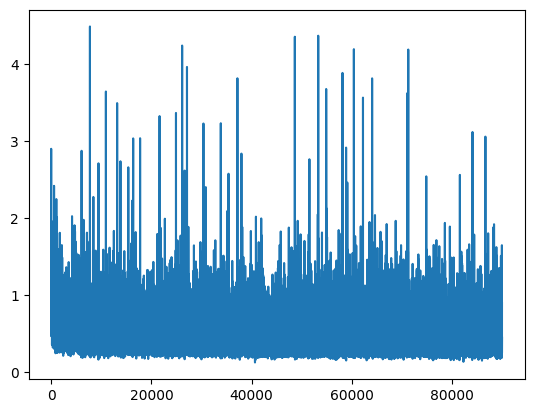

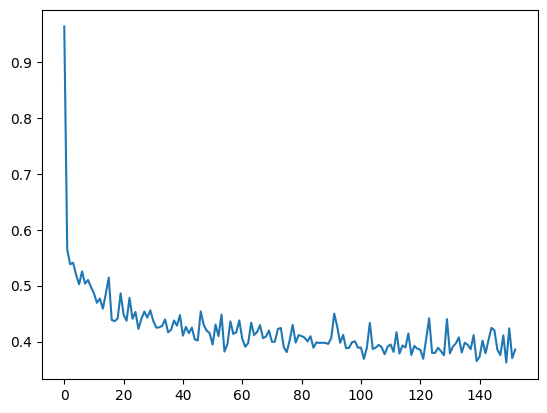

In [34]:
plt.plot(train_loss)
plt.show()
plt.plot(val_loss)
plt.show()

### Testing

In [32]:
from pythonosc import udp_client
import time
import sounddevice as sd

In [104]:
test_data = CustomDataset(args, "test")
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=1,  
    shuffle=True,  
    drop_last=False,
)

In [105]:
data = next(iter(test_loader))

In [106]:
facial = data["facial"]
audio = data["audio"]

In [107]:
mean_facial = np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_mean.npy")
std_facial = np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_std.npy")
mean_audio = np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_mean.npy")
std_audio = np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_std.npy")

In [108]:
out_facial = facial * std_facial + mean_facial
out_audio = audio * std_audio + mean_audio

In [109]:
# Try playing the audio, which is at 16KHZ
print(out_facial.min(), out_facial.max())
print(out_audio.min(), out_audio.max())

tensor(-2.9796e-09, dtype=torch.float64) tensor(0.9395, dtype=torch.float64)
tensor(-0.5958) tensor(0.5204)


In [110]:
out_audio.shape

torch.Size([1, 480000])

In [88]:
blend =  [
        "browDownLeft",
        "browDownRight",
        "browInnerUp",
        "browOuterUpLeft",
        "browOuterUpRight",
        "cheekPuff",
        "cheekSquintLeft",
        "cheekSquintRight",
        "eyeBlinkLeft",
        "eyeBlinkRight",
        "eyeLookDownLeft",
        "eyeLookDownRight",
        "eyeLookInLeft",
        "eyeLookInRight",
        "eyeLookOutLeft",
        "eyeLookOutRight",
        "eyeLookUpLeft",
        "eyeLookUpRight",
        "eyeSquintLeft",
        "eyeSquintRight",
        "eyeWideLeft",
        "eyeWideRight",
        "jawForward",
        "jawLeft",
        "jawOpen",
        "jawRight",
        "mouthClose",
        "mouthDimpleLeft",
        "mouthDimpleRight",
        "mouthFrownLeft",
        "mouthFrownRight",
        "mouthFunnel",
        "mouthLeft",
        "mouthLowerDownLeft",
        "mouthLowerDownRight",
        "mouthPressLeft",
        "mouthPressRight",
        "mouthPucker",
        "mouthRight",
        "mouthRollLower",
        "mouthRollUpper",
        "mouthShrugLower",
        "mouthShrugUpper",
        "mouthSmileLeft",
        "mouthSmileRight",
        "mouthStretchLeft",
        "mouthStretchRight",
        "mouthUpperUpLeft",
        "mouthUpperUpRight",
        "noseSneerLeft",
        "noseSneerRight",
        "tongueOut"
    ]

In [89]:
def play_audio(out_audio, init_time):
    time.sleep(init_time - time.time())
    sd.play(out_audio, 16000)
    sd.wait()

In [90]:

def send_udp(out_face, init_time):
    #outWeight = np.zeros(52)

    ##need to implement get value in
    outWeight = out_face

    outWeight = outWeight * (outWeight >= 0)

    client = udp_client.SimpleUDPClient('127.0.0.1', 5008)
    osc_array = outWeight.tolist()
    
    fps = 15
    time.sleep(init_time - time.time())
    for i in range(len(osc_array)):
        start_time = time.time()
        #print(out_face[i].shape)
        for j, out in enumerate(osc_array[i]):
            client.send_message('/' + str(blend[j]), out)

        elpased_time = time.time() - start_time
        sleep_time = 1.0/fps - elpased_time
        if sleep_time > 0:
            time.sleep(sleep_time)

In [111]:
import threading

init_time = time.time() + 3

udp_thread = threading.Thread(target=send_udp, args=(out_facial[0],init_time))
udp_thread.daemon = True  # Set the thread as a daemon to allow it to exit when the main program exits

audio_thread = threading.Thread(target=play_audio, args=(out_audio[0],init_time))
audio_thread.daemon = True

udp_thread.start()
audio_thread.start()

udp_thread.join()
audio_thread.join()

In [112]:
print(len(out_audio[0])/16000, len(out_facial[0])/15)

30.0 30.0


In [113]:
 # load in model
from scripts.SimpleNet import FaceGenerator
model_path = 'ckpt_model/simplenet1.pth'
net = FaceGenerator()
net.load_state_dict(torch.load(model_path))
net = net.cuda().eval()

In [115]:
in_audio = audio.cuda()
in_facial = facial.cuda()
pre_frames = 4
in_pre_facial = in_facial.new_zeros((in_facial.shape[0], in_facial.shape[1]-5, in_facial.shape[2] + 1)).cuda() #-5 for now for temp bug fix
in_pre_facial[:, 0:pre_frames, :-1] = in_facial[:, 0:pre_frames]
in_pre_facial[:, 0:pre_frames, -1] = 1 

pred_facial = net(in_pre_facial,in_audio).cpu().detach().numpy() * std_facial + mean_facial

In [116]:
pred_facial.min(), pred_facial.max()

(-0.030237639886076112, 0.5012873196177369)

In [117]:
import threading

init_time = time.time() + 3

udp_thread = threading.Thread(target=send_udp, args=(pred_facial[0],init_time))
udp_thread.daemon = True  # Set the thread as a daemon to allow it to exit when the main program exits

audio_thread = threading.Thread(target=play_audio, args=(out_audio[0],init_time))
audio_thread.daemon = True

udp_thread.start()
audio_thread.start()

udp_thread.join()
audio_thread.join()